In [1]:
import cv2, os, re, numpy as np
from skimage.metrics import structural_similarity as ssim
import pytesseract
from difflib import SequenceMatcher
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

pytesseract.pytesseract.tesseract_cmd = r'D:\Apps\Tesseract-OCR\tesseract.exe'

def load_cases():
    mapping = {
        'identical': 'similar',
        'font_color': 'similar',      
        'text_changes': 'almost',
        'layout_changes': 'almost',
        'changes': 'different',
        'completely_different': 'different'
    }
    cases, groups = [], []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"

    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m: continue
        group_id = int(m.group(1))
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir): continue
        for vf in os.listdir(vidir):
            label_name = vf.split('.')[0].lower()  
            label = mapping.get(label_name)
            if label: 
                cases.append((os.path.join(ori_dir,f), os.path.join(vidir,vf), label))
                groups.append(group_id)
    return cases, groups

class FeatureRandomForest:
    def __init__(self):
        self.model = RandomForestClassifier(
            n_estimators = 140,
            max_depth = 10,
            max_features = 'sqrt',
            min_samples_leaf = 2,
            min_samples_split = 6,
            random_state = 42
        )
        
        self.orbs = cv2.ORB_create(nfeatures=150)
        self.map = {'similar':0,'almost':1,'different':2}
        self.names = ['Similar','Almost','Different']
        self._ocr_cache = {}

    def prep_gray(self, img):
        g = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels = 700_000
        h, w = g.shape
        if h * w > max_pixels:
            s = (max_pixels / (h * w)) ** 0.5
            g = cv2.resize(g, (int(w * s), int(h * s)))
        g = cv2.medianBlur(g, 3)
        return g
    
    def ensure_same_size(self, g1, g2):
        if g1 is None or g2 is None: return None, None
        if g1.shape == g2.shape: return g1, g2
        h1, w1 = g1.shape
        g2 = cv2.resize(g2, (w1, h1))  
        return g1, g2

    def ssim(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            g1, g2 = self.ensure_same_size(g1, g2)
            if g1 is None or g2 is None: return 0.5
            val = ssim(g1, g2, data_range=255) 
            return float(np.clip(val, 0.0, 1.0))
        except: return 0.5

    def ocr(self, a, b):
        def get_words(p, gimg):
            if p in self._ocr_cache: return self._ocr_cache[p]
            bw = cv2.adaptiveThreshold(gimg, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 21, 8)
            txt = pytesseract.image_to_string(bw, config="--oem 3 --psm 6")
            ws = re.sub(r'[^A-Za-z0-9 ]+', ' ', txt).lower().split()
            self._ocr_cache[p] = ws
            return ws
        try:
            g1 = self.prep_gray(a); g2 = self.prep_gray(b)
            if g1 is None or g2 is None: return 0.5
            t1 = get_words(a, g1); t2 = get_words(b, g2)
            s1, s2 = set(t1), set(t2)
            if not s1 and not s2: return 0.8      
            if not s1 or not s2:  return 0.3      
            jacc = len(s1 & s2) / len(s1 | s2)   
            return float(jacc)
        except:
            return 0.5

    def hist(self, a, b):
        try:
            c1 = cv2.imread(a)
            c2 = cv2.imread(b)
            if c1 is None or c2 is None: return 0.5
            bins = 32
            vals = []
            for ch in range(3):
                h1 = cv2.calcHist([c1], [ch], None, [bins], [0, 256])
                h2 = cv2.calcHist([c2], [ch], None, [bins], [0, 256])
                cv2.normalize(h1, h1, alpha=1.0, norm_type=cv2.NORM_L1)
                cv2.normalize(h2, h2, alpha=1.0, norm_type=cv2.NORM_L1)
                vals.append((cv2.compareHist(h1, h2, cv2.HISTCMP_CORREL) + 1) / 2)
            return float(np.mean(vals))
        except: return 0.5

    def orb(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            kp1, d1 = self.orbs.detectAndCompute(g1, None)
            kp2, d2 = self.orbs.detectAndCompute(g2, None)
            if d1 is None or d2 is None: return 0.5
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
            knn = bf.knnMatch(d1, d2, k=2)
            good = []
            for pr in knn:
                if len(pr) < 2: continue
                m, n = pr
                if m.distance < 0.75 * n.distance: good.append(m)
            if not good: return 0.5
            ratio = len(good) / max(1, min(len(kp1), len(kp2)))
            quality = 1 - np.mean([m.distance for m in good]) / 256.0
            return float(np.clip(0.5 * ratio + 0.5 * quality, 0, 1))
        except: return 0.5

    def layout(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            g1, g2 = self.ensure_same_size(g1, g2)
            if g1 is None or g2 is None: return 0.5
            e1 = cv2.Canny(g1, 50, 150) > 0
            e2 = cv2.Canny(g2, 50, 150) > 0
            inter = np.logical_and(e1, e2).sum()
            uni = np.logical_or(e1, e2).sum()
            if uni == 0: return 1.0
            return float(inter/uni)
        except: 
            return 0.5

    def feat(self,a,b):
        return [self.ssim(a,b), self.ocr(a,b), self.hist(a,b), self.orb(a,b), self.layout(a,b)]

    def train_eval(self, cases, groups):
        X = [self.feat(a,b) for a,b,l in cases]
        y = [self.map[l] for _,_,l in cases]
        
        from collections import Counter
        label_counts = Counter([label for _, _, label in cases])
        print("Label distribution:", dict(label_counts))
        
        gkf = GroupKFold(n_splits=5)  
        accuracies = []
        fold = 1
        
        for train_idx, test_idx in gkf.split(X, y, groups):
            Xtr = [X[i] for i in train_idx]
            ytr = [y[i] for i in train_idx]
            Xte = [X[i] for i in test_idx]
            yte = [y[i] for i in test_idx]
            
            self.model.fit(Xtr, ytr)  
            yp = self.model.predict(Xte) 

            acc = (yp==yte).mean()*100
            accuracies.append(acc)
            
            print(f"Fold {fold} - RF: {acc:.1f}%")
            print(classification_report(yte, yp, target_names=self.names))
            print(confusion_matrix(yte, yp))
            fold += 1

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"Mean Accuracy: {mean_acc:.1f}%")
        print(f"Std Accuracy: {std_acc:.1f}%")
            
        return mean_acc, std_acc

cases, groups = load_cases()
print(f"{len(cases)} cases from {len(set(groups))} groups")
rf_model = FeatureRandomForest()
rf_mean, rf_std = rf_model.train_eval(cases, groups)

360 cases from 60 groups
Label distribution: {'different': 120, 'similar': 120, 'almost': 120}
Fold 1 - RF: 86.1%
              precision    recall  f1-score   support

     Similar       0.88      0.92      0.90        24
      Almost       0.94      0.67      0.78        24
   Different       0.80      1.00      0.89        24

    accuracy                           0.86        72
   macro avg       0.87      0.86      0.86        72
weighted avg       0.87      0.86      0.86        72

[[22  1  1]
 [ 3 16  5]
 [ 0  0 24]]
Fold 2 - RF: 86.1%
              precision    recall  f1-score   support

     Similar       0.79      0.96      0.87        24
      Almost       0.86      0.79      0.83        24
   Different       0.95      0.83      0.89        24

    accuracy                           0.86        72
   macro avg       0.87      0.86      0.86        72
weighted avg       0.87      0.86      0.86        72

[[23  1  0]
 [ 4 19  1]
 [ 2  2 20]]
Fold 3 - RF: 87.5%
            

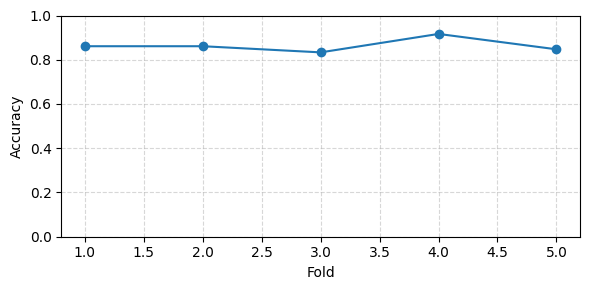

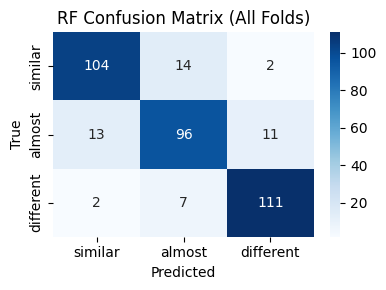

\nClassification Report (Aggregated CV):
              precision    recall  f1-score   support

     Similar       0.87      0.87      0.87       120
      Almost       0.82      0.80      0.81       120
   Different       0.90      0.93      0.91       120

    accuracy                           0.86       360
   macro avg       0.86      0.86      0.86       360
weighted avg       0.86      0.86      0.86       360



In [2]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score

def build_feature_df_rf(model, cases, groups):
    rows=[]
    for (a,b,l), g in zip(cases, groups):
        f = model.feat(a,b)
        row = {'SSIM':f[0],'OCR':f[1],'Hist':f[2],'ORB':f[3],'Layout':f[4],
               'label':l,'group':g}
        rows.append(row)
    return pd.DataFrame(rows)

if 'df_rf' not in globals():
    df_rf = build_feature_df_rf(rf_model, cases, groups)

label_order = ['similar','almost','different']
feat_cols = ['SSIM','OCR','Hist','ORB','Layout']

gkf = GroupKFold(n_splits=5)
X_all = df_rf[feat_cols].values
y_all = df_rf['label'].values
accs=[]; all_true=[]; all_pred=[]

for fold,(tr,te) in enumerate(gkf.split(X_all, y_all, groups),1):
    Xtr,Xte = X_all[tr], X_all[te]
    ytr,yte = y_all[tr], y_all[te]

    from sklearn.ensemble import RandomForestClassifier
    rf_fold = RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
        random_state=42
    )
    rf_fold.fit(Xtr, [rf_model.map[l] for l in ytr])
    yp_int = rf_fold.predict(Xte)
    inv_map = {v:k for k,v in rf_model.map.items()}
    yp = [inv_map[i] for i in yp_int]
    accs.append(accuracy_score(yte, yp))
    all_true.extend(yte); all_pred.extend(yp)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(accs)+1), accs, marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.grid(ls='--',alpha=.5)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_true, all_pred, labels=label_order)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order, yticklabels=label_order)
plt.title('RF Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print('\\nClassification Report (Aggregated CV):')
print(classification_report(all_true, all_pred, labels=label_order, target_names=['Similar','Almost','Different']))

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

X = [rf_model.feat(a,b) for a,b,l in cases]
y = [rf_model.map[l] for _,_,l in cases]

pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [80,100,120,140,160],
    'model__max_depth': [8,10,12,15],
    'model__min_samples_split': [2,4,5,6],
    'model__min_samples_leaf': [1,2,4],
    'model__max_features': ['sqrt','log2']
}

cv = GroupKFold(n_splits=5)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    refit=True
)

gs.fit(X, y, groups=groups)

best_params = gs.best_params_
print("RF Best params (inner CV):", best_params)
print(f"RF Inner CV accuracy: {gs.best_score_*100:.2f}%")

rf_tuned = FeatureRandomForest()
rf_tuned.model = RandomForestClassifier(
    n_estimators=best_params['model__n_estimators'],
    max_depth=best_params['model__max_depth'],
    min_samples_split=best_params['model__min_samples_split'],
    min_samples_leaf=best_params['model__min_samples_leaf'],
    max_features=best_params['model__max_features'],
    random_state=42
)

outer = GroupKFold(n_splits=5)
accs = []
all_true = []; all_pred = []

for fold, (tr, te) in enumerate(outer.split(X, y, groups), 1):
    Xtr = [X[i] for i in tr]; Xte = [X[i] for i in te]
    ytr = [y[i] for i in tr]; yte = [y[i] for i in te]
    
    rf_tuned.model.fit(Xtr, ytr)
    yp = rf_tuned.model.predict(Xte)
    
    acc = (np.array(yp) == np.array(yte)).mean()
    accs.append(acc)
    print(f"Fold {fold}: {acc*100:.2f}%")
    all_true.extend(yte); all_pred.extend(yp)

print(f"\nRF Accuracy: {np.mean(accs)*100:.2f}% ± {np.std(accs)*100:.2f}%")

rf_tuned.model.fit(X, y)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
RF Best params (inner CV): {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 6, 'model__n_estimators': 140}
RF Inner CV accuracy: 87.78%
Fold 1: 86.11%
Fold 2: 86.11%
Fold 3: 87.50%
Fold 4: 94.44%
Fold 5: 84.72%

RF Accuracy: 87.78% ± 3.45%


,n_estimators,140
,criterion,'gini'
,max_depth,10
,min_samples_split,6
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



RandomForest Feature Importances:
 - Layout: 0.2630
 - SSIM: 0.2605
 - Hist: 0.2562
 - ORB: 0.1144
 - OCR: 0.1060


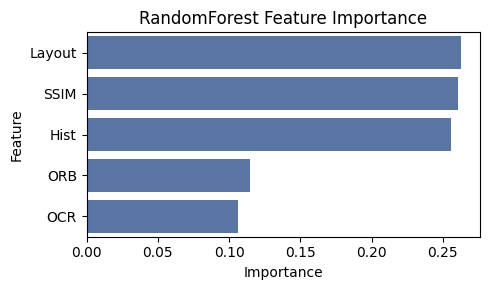

In [4]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
feat_names = ["SSIM","OCR","Hist","ORB","Layout"]
fi = rf_tuned.model.feature_importances_
order = np.argsort(fi)[::-1]

print("\nRandomForest Feature Importances:")
for i in order:
    print(f" - {feat_names[i]}: {fi[i]:.4f}")

plt.figure(figsize=(5,3))
sns.barplot(x=fi[order], y=[feat_names[i] for i in order], color="#4C72B0")
plt.title("RandomForest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [5]:
# import os, json, time, joblib

# os.makedirs("artifacts", exist_ok=True)

# joblib.dump(rf_tuned.model, "artifacts/model.pkl")

# meta = {
#     "model": "RandomForest",
#     "version": "1.0.0", 
#     "features": ["SSIM","OCR","Hist","ORB","Layout"],
#     "label_map": rf_model.map,  
#     "built_at": time.strftime("%Y-%m-%d %H:%M:%S")
# }
# json.dump(meta, open("artifacts/metadata.json","w"), indent=2, ensure_ascii=False)
# print("Success")